In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

Saving figure time_series_plot


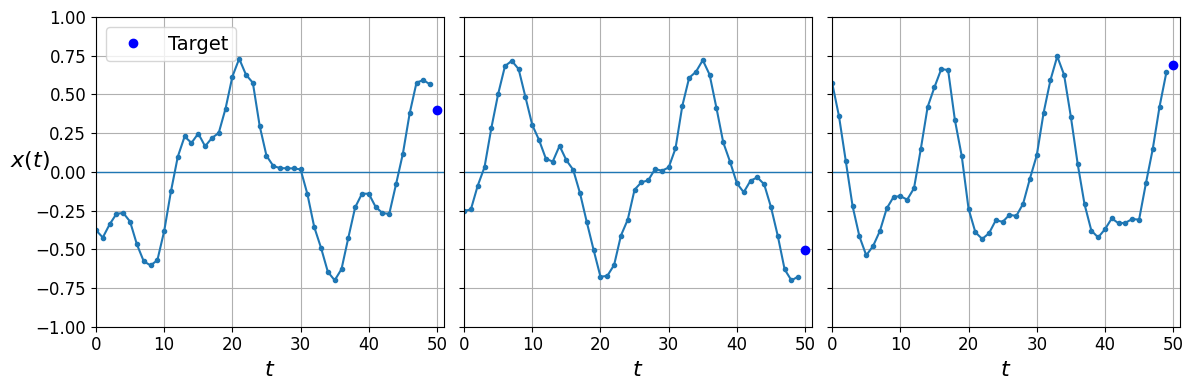

In [4]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
save_fig("time_series_plot")
plt.show()

In [5]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

In [6]:
y_pred.shape

(2000, 1)

In [7]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=[X_valid, y_valid])

Epoch 1/20
219/219 [==============================] - 9s 8ms/step - loss: 0.1979 - val_loss: 0.0292
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0183 - val_loss: 0.0139
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0112 - val_loss: 0.0099
Epoch 4/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0082
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0067 - val_loss: 0.0068
Epoch 7/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 8/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0059 - val_loss: 0.0060
Epoch 9/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0056 - val_loss: 0.0057
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0053 - val_loss: 0.0055

In [8]:
model.evaluate(X_valid, y_valid)

y_pred = model.predict(X_valid)
mse = np.mean(keras.losses.mean_squared_error(y_valid, y_pred))
mse

63/63 [==============================] - 0s 1ms/step


0.0040578013

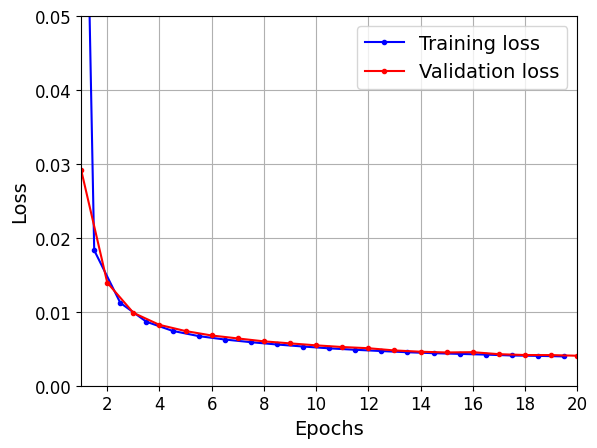

In [9]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [10]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [11]:
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20, validation_data=[X_valid, y_valid])

Epoch 1/20
219/219 [==============================] - 9s 36ms/step - loss: 0.0987 - val_loss: 0.0468
Epoch 2/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0359 - val_loss: 0.0290
Epoch 3/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0249 - val_loss: 0.0215
Epoch 4/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0196 - val_loss: 0.0175
Epoch 5/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0164 - val_loss: 0.0150
Epoch 6/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0145 - val_loss: 0.0133
Epoch 7/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0123 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0116 - val_lo

In [12]:
y_pred = model.predict(X_valid)
mse = np.mean(keras.losses.mean_squared_error(y_valid, y_pred))
mse

63/63 [==============================] - 1s 8ms/step


0.010882547

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
# history = model.fit(X_train, y_train, epochs=20,
#                     validation_data=(X_valid, y_valid))

In [14]:
# y_pred = model.predict(X_valid)
# mse = np.mean(keras.losses.mean_squared_error(y_valid, y_pred))
# mse
# model.evaluate(X_valid, y_valid)

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 22s 89ms/step - loss: 0.0141 - val_loss: 0.0047
Epoch 2/20
219/219 [==============================] - 20s 94ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 3/20
219/219 [==============================] - 20s 92ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 4/20
219/219 [==============================] - 19s 87ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 21s 96ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 6/20
219/219 [==============================] - 21s 97ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 7/20
219/219 [==============================] - 19s 88ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 8/20
219/219 [==============================] - 21s 95ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 9/20
219/219 [==============================] - 19s 88ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 10/20
219/219 [==============================] - 20s 93ms/step - loss: 0.002

In [16]:
y_pred = model.predict(X_valid)
mse = np.mean(keras.losses.mean_squared_error(y_valid, y_pred))
mse
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 10ms/step - loss: 0.0025


0.00254243821837008

In [17]:
np.random.seed(43)

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
  y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
  X = np.concatenate([X, y_pred_one], axis=1)


Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 26ms/step


Saving figure forecast_ahead_plot


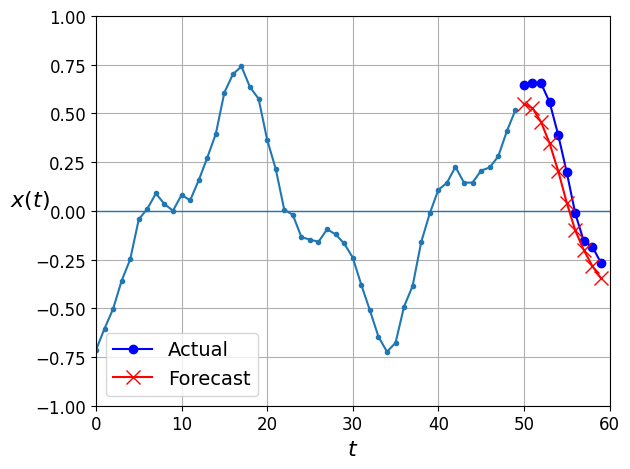

In [18]:
def plot_multiple_forecasts(X, Y, Y_pred):
  n_steps = X.shape[1]
  ahead = Y.shape[1]
  plot_series(X[0, :, 0])
  plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
  plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
  plt.axis([0, n_steps + ahead, -1, 1])
  plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

In [19]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [20]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
# history = model.fit(X_train, Y_train, epochs=20,
#                     validation_data=(X_valid, Y_valid))

In [21]:
# np.random.seed(43)

# series = generate_time_series(1, 50 + 10)
# X_new, Y_new = series[:, :50, :], series[:, -10:, :]
# Y_pred = model.predict(X_new)[..., np.newaxis]
# plot_multiple_forecasts(X_new, Y_new, Y_pred)
# plt.show()
# Y_pred.shape

In [22]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [23]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
# history = model.fit(X_train, Y_train, epochs=20,
#                     validation_data=(X_valid, Y_valid))

In [24]:
# np.random.seed(43)

# series = generate_time_series(1, 50 + 10)
# X_new, Y_new = series[:, :50, :], series[:, 50:, :]
# Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
# plot_multiple_forecasts(X_new, Y_new, Y_pred)
# plt.show()

In [25]:
from tensorflow.keras.layers import LayerNormalization

class LNSimpleRNNCell(keras.layers.Layer):
  def __init__(self, units, activation="tanh", **kwargs):
    super().__init__(**kwargs)
    self.state_size = units
    self.output_size = units
    self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                      activation=None)
    self.layer_norm = LayerNormalization()
    self.activation = keras.activations.get(activation)

  def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
    if inputs is not None:
      batch_size = tf.shape(inputs)[0]
      dtype = inputs.dtype
    return [tf.zeros([batch_size, self.state_size], dtype=dtype)]

  def call(self, inputs, states):
    outputs, new_states = self.simple_rnn_cell(inputs, states)
    norm_outputs = self.activation(self.layer_norm(outputs))
    return norm_outputs, [norm_outputs]

In [26]:
model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
# history = model.fit(X_train, Y_train, epochs=20,
#                     validation_data=(X_valid, Y_valid))

In [27]:
class MyRNN(keras.layers.Layer):
  def __init__(self, cell, return_sequences=False, **kwargs):
    super().__init__(**kwargs)
    self.cell = cell
    self.return_sequences = return_sequences
    self.get_initial_state = getattr(
      self.cell, "get_initial_state", self.fallback_initial_state)
  def fallback_initial_state(self, inputs):
    batch_size = tf.shape(inputs)[0]
    return [tf.zeros([batch_size, self.cell.state_size], dtype=inputs.dtype)]
  @tf.function
  def call(self, inputs):
    states = self.get_initial_state(inputs)
    shape = tf.shape(inputs)
    batch_size = shape[0]
    n_steps = shape[1]
    sequences = tf.TensorArray(
      inputs.dtype, size=(n_steps if self.return_sequences else 0))
    outputs = tf.zeros(shape=[batch_size, self.cell.output_size], dtype=inputs.dtype)
    for step in tf.range(n_steps):
      outputs, states = self.cell(inputs[:, step], states)
      if self.return_sequences:
          sequences = sequences.write(step, outputs)
    if self.return_sequences:
      return tf.transpose(sequences.stack(), [1, 0, 2])
    else:
      return outputs

In [28]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
# history = model.fit(X_train, Y_train, epochs=20,
#                     validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 50s 213ms/step - loss: 0.1472 - last_time_step_mse: 0.1295 - val_loss: 0.0710 - val_last_time_step_mse: 0.0585
Epoch 2/20
219/219 [==============================] - 45s 207ms/step - loss: 0.0588 - last_time_step_mse: 0.0458 - val_loss: 0.0533 - val_last_time_step_mse: 0.0423
Epoch 3/20
219/219 [==============================] - 61s 277ms/step - loss: 0.0509 - last_time_step_mse: 0.0391 - val_loss: 0.0543 - val_last_time_step_mse: 0.0409
Epoch 4/20
219/219 [==============================] - 45s 202ms/step - loss: 0.0467 - last_time_step_mse: 0.0361 - val_loss: 0.0446 - val_last_time_step_mse: 0.0308
Epoch 5/20
219/219 [==============================] - 49s 223ms/step - loss: 0.0436 - last_time_step_mse: 0.0320 - val_loss: 0.0457 - val_last_time_step_mse: 0.0378
Epoch 6/20
219/219 [==============================] - 47s 215ms/step - loss: 0.0458 - last_time_step_mse: 0.0314 - val_loss: 0.0423 - val_last_time_step_mse: 0.0269
Epoch 7/20

In [29]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 8s 12ms/step - loss: 0.0770 - last_time_step_mse: 0.0613 - val_loss: 0.0533 - val_last_time_step_mse: 0.0317
Epoch 2/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0463 - last_time_step_mse: 0.0245 - val_loss: 0.0412 - val_last_time_step_mse: 0.0201
Epoch 3/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0378 - last_time_step_mse: 0.0167 - val_loss: 0.0360 - val_last_time_step_mse: 0.0168
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0340 - last_time_step_mse: 0.0145 - val_loss: 0.0328 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0320 - last_time_step_mse: 0.0135 - val_loss: 0.0311 - val_last_time_step_mse: 0.0128
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0306 - last_time_step_mse: 0.0126 - val_loss: 0.0298 - val_last_time_step_mse: 0.0121
Epoch 7/20
219/219 [=====

63/63 [==============================] - 0s 4ms/step - loss: 0.0201 - last_time_step_mse: 0.0051


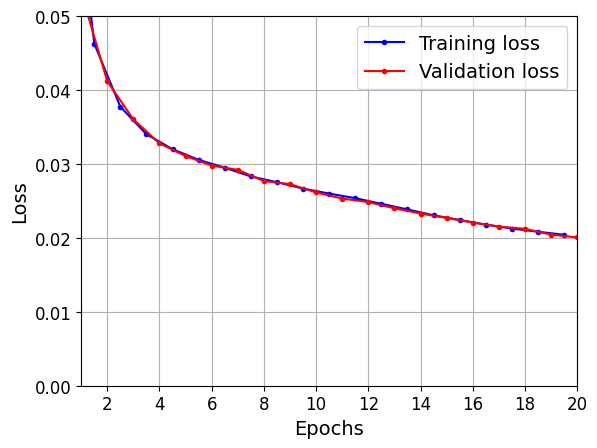

In [30]:
model.evaluate(X_valid, Y_valid)
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

1/1 [==============================] - 1s 876ms/step


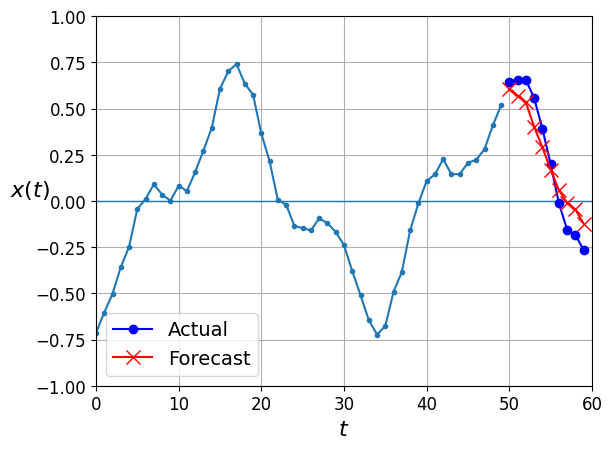

In [31]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 11ms/step - loss: 0.0768 - last_time_step_mse: 0.0673 - val_loss: 0.0568 - val_last_time_step_mse: 0.0455
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0510 - last_time_step_mse: 0.0403 - val_loss: 0.0462 - val_last_time_step_mse: 0.0352
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0436 - last_time_step_mse: 0.0322 - val_loss: 0.0410 - val_last_time_step_mse: 0.0294
Epoch 4/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0387 - last_time_step_mse: 0.0260 - val_loss: 0.0360 - val_last_time_step_mse: 0.0218
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0350 - last_time_step_mse: 0.0210 - val_loss: 0.0336 - val_last_time_step_mse: 0.0188
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0328 - last_time_step_mse: 0.0180 - val_loss: 0.0313 - val_last_time_step_mse: 0.0159
Epoch 7/20
219/219 [======

63/63 [==============================] - 0s 4ms/step - loss: 0.0247 - last_time_step_mse: 0.0106


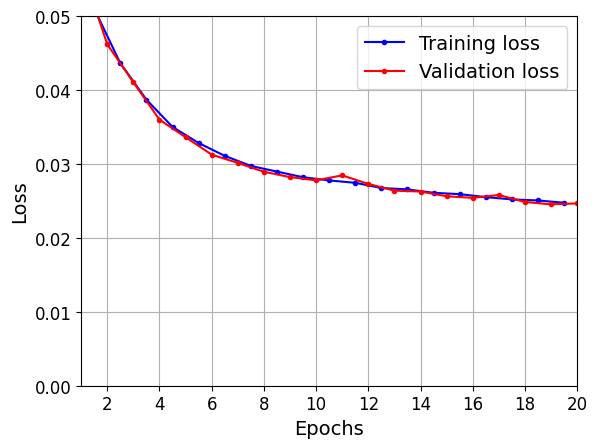

In [33]:
model.evaluate(X_valid, Y_valid)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

1/1 [==============================] - 1s 548ms/step


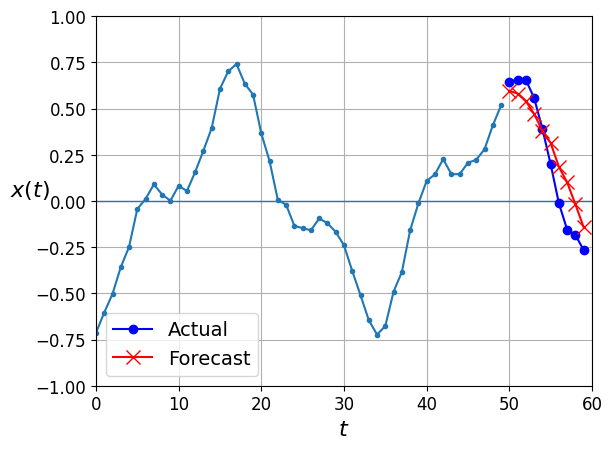

In [34]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [35]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                      input_shape=[None, 1]),
  keras.layers.GRU(20, return_sequences=True),
  keras.layers.GRU(20, return_sequences=True),
  keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 12s 11ms/step - loss: 0.0674 - last_time_step_mse: 0.0598 - val_loss: 0.0433 - val_last_time_step_mse: 0.0344
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0391 - last_time_step_mse: 0.0312 - val_loss: 0.0358 - val_last_time_step_mse: 0.0274
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0329 - last_time_step_mse: 0.0244 - val_loss: 0.0305 - val_last_time_step_mse: 0.0214
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0285 - last_time_step_mse: 0.0186 - val_loss: 0.0274 - val_last_time_step_mse: 0.0177
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0254 - last_time_step_mse: 0.0146 - val_loss: 0.0248 - val_last_time_step_mse: 0.0143
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0238 - last_time_step_mse: 0.0127 - val_loss: 0.0231 - val_last_time_step_mse: 0.0121
Epoch 7/20
219/219 [======

In [36]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
  model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 10ms/step - loss: 0.0641 - last_time_step_mse: 0.0511 - val_loss: 0.0359 - val_last_time_step_mse: 0.0219
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0325 - last_time_step_mse: 0.0196 - val_loss: 0.0299 - val_last_time_step_mse: 0.0173
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0286 - last_time_step_mse: 0.0159 - val_loss: 0.0274 - val_last_time_step_mse: 0.0151
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0267 - last_time_step_mse: 0.0143 - val_loss: 0.0260 - val_last_time_step_mse: 0.0139
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0255 - last_time_step_mse: 0.0132 - val_loss: 0.0249 - val_last_time_step_mse: 0.0126
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0244 - last_time_step_mse: 0.0122 - val_loss: 0.0241 - val_last_time_step_mse: 0.0116
Epoch 7/20
219/219 [======

In [37]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

Epoch 1/2
219/219 [==============================] - 7s 11ms/step - loss: 0.1284 - last_time_step_mse: 0.1241 - val_loss: 0.1224 - val_last_time_step_mse: 0.1193
Epoch 2/2
219/219 [==============================] - 2s 8ms/step - loss: 0.1220 - last_time_step_mse: 0.1176 - val_loss: 0.1217 - val_last_time_step_mse: 0.1188


In [38]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

1065301781/1065301781 [==============================] - 37s 0us/step


In [38]:
quickdraw_dir

In [39]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()

with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [40]:
def parse(data_batch):
  feature_descriptions = {
    "ink": tf.io.VarLenFeature(dtype=tf.float32),
    "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
    "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
  }
  examples = tf.io.parse_example(data_batch, feature_descriptions)
  flat_sketches = tf.sparse.to_dense(examples["ink"])
  sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
  lengths = examples["shape"][:, 0]
  labels = examples["class_index"][:, 0]
  return sketches, lengths, labels

In [41]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
  dataset = tf.data.TFRecordDataset(filepaths,
                                    num_parallel_reads=n_read_threads)
  if cache:
      dataset = dataset.cache()
  if shuffle_buffer_size:
      dataset = dataset.shuffle(shuffle_buffer_size)
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
  return dataset.prefetch(1)

In [42]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [43]:
for sketches, lengths, labels in train_set.take(1):
  print("sketches =", sketches)
  print("lengths =", lengths)
  print("labels =", labels)

sketches = tf.Tensor(
[[[-0.0944882  -0.04663213  0.        ]
  [-0.08661417  0.04145078  0.        ]
  [-0.03937007  0.05181348  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.04313726 -0.14960629  0.        ]
  [ 0.06274509 -0.40551183  0.        ]
  [ 0.04313726 -0.12598425  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          1.        ]
  [ 0.          0.          0.        ]
  [-0.19607842 -0.03174603  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.12790698  0.01960784  0.        ]
  [-0.02906978  0.2117647   0.        ]
  [-0.04651159  0.06274509  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

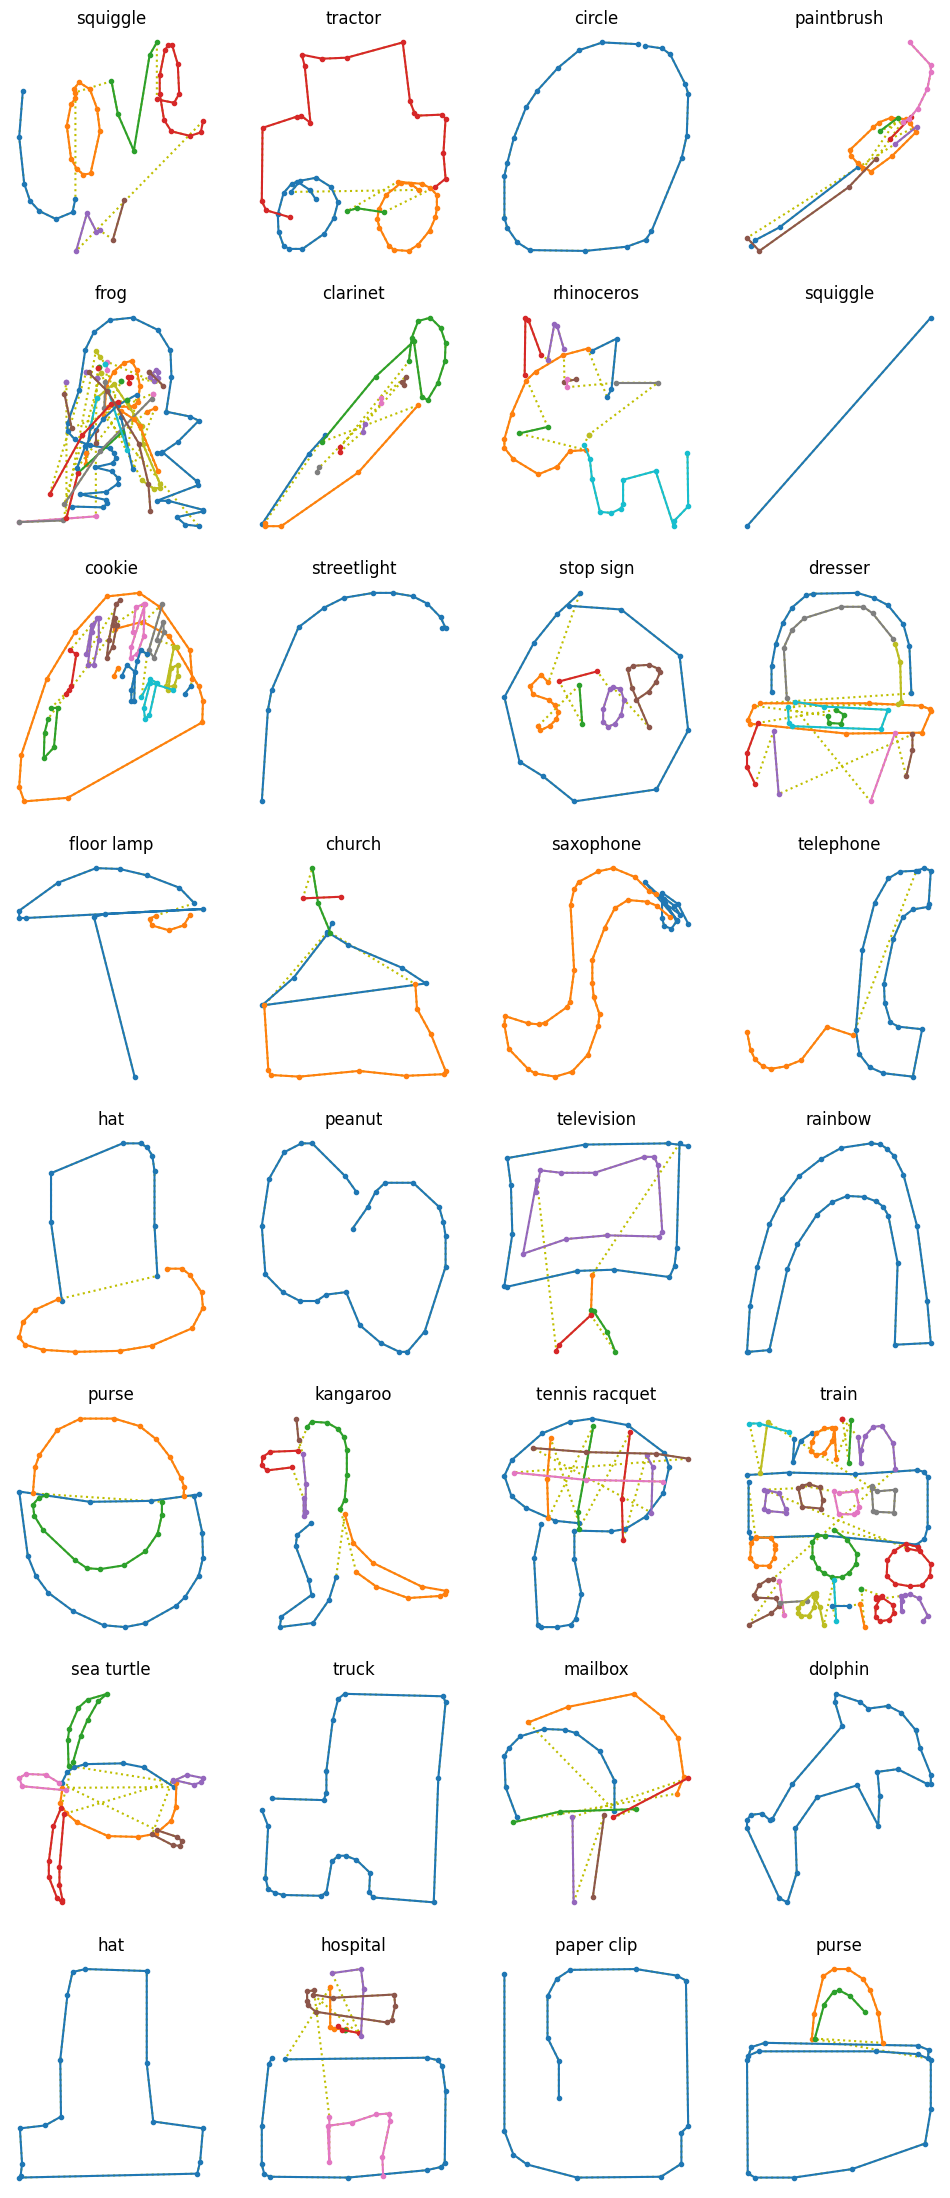

In [44]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

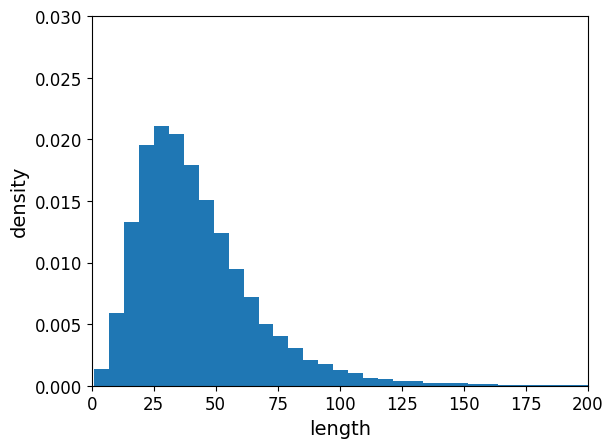

In [45]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [49]:
def crop_long_sketches(dataset, max_length=100):
  return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)


In [46]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
# history = model.fit(cropped_train_set, epochs=2,
#                     validation_data=cropped_valid_set)

In [ ]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

In [ ]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [ ]:
model.save("my_sketchrnn")

In [50]:
DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/raw/master/datasets/jsb_chorales/"
FILENAME = "jsb_chorales.tgz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/jsb_chorales",
                                extract=True)
jsb_chorales_dir = Path(filepath).parent
train_files = sorted(jsb_chorales_dir.glob("train/chorale_*.csv"))
valid_files = sorted(jsb_chorales_dir.glob("valid/chorale_*.csv"))
test_files = sorted(jsb_chorales_dir.glob("test/chorale_*.csv"))

117661/117661 [==============================] - 0s 0us/step


In [51]:
import pandas as pd

def load_chorales(filepaths):
  return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales = load_chorales(test_files)
train_chorales[0]

[[74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [75, 70, 58, 55],
 [75, 70, 58, 55],
 [75, 70, 60, 55],
 [75, 70, 60, 55],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 70, 62, 55],
 [77, 70, 62, 55],
 [77, 69, 62, 55],
 [77, 69, 62, 55],
 [75, 67, 63, 48],
 [75, 67, 63, 48],
 [75, 69, 63, 48],
 [75, 69, 63, 48],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [75, 69, 63, 48],
 [75, 69, 63, 48],
 [75, 67, 63, 48],
 [75, 67, 63, 48],
 [77, 65, 62, 50],
 [77, 65, 62, 50],
 [77, 65, 60, 50],
 [77, 65, 60, 50],
 [74, 67, 58, 55],
 [74, 67, 58, 55],
 [74, 67, 58, 53],
 [74, 67, 58, 53],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 65, 57

In [52]:
notes = set()
for chorales in (train_chorales, valid_chorales, test_chorales):
  for chorale in chorales:
    for chord in chorale:
      notes |= set(chord)

n_notes = len(notes)
min_note = min(notes - {0}) # without pause
max_note = max(notes)

assert min_note == 36 # C1
assert max_note == 81 # A5

In [53]:
from IPython.display import Audio

def notes_to_frequencies(notes):
    # Frequency doubles when you go up one octave; there are 12 semi-tones
    # per octave; Note A on octave 4 is 440 Hz, and it is note number 69.
    return 2 ** ((np.array(notes) - 69) / 12) * 440

def frequencies_to_samples(frequencies, tempo, sample_rate):
    note_duration = 60 / tempo # the tempo is measured in beats per minutes
    # To reduce click sound at every beat, we round the frequencies to try to
    # get the samples close to zero at the end of each note.
    frequencies = np.round(note_duration * frequencies) / note_duration
    n_samples = int(note_duration * sample_rate)
    time = np.linspace(0, note_duration, n_samples)
    sine_waves = np.sin(2 * np.pi * frequencies.reshape(-1, 1) * time)
    # Removing all notes with frequencies ≤ 9 Hz (includes note 0 = silence)
    sine_waves *= (frequencies > 9.).reshape(-1, 1)
    return sine_waves.reshape(-1)

def chords_to_samples(chords, tempo, sample_rate):
    freqs = notes_to_frequencies(chords)
    freqs = np.r_[freqs, freqs[-1:]] # make last note a bit longer
    merged = np.mean([frequencies_to_samples(melody, tempo, sample_rate)
                     for melody in freqs.T], axis=0)
    n_fade_out_samples = sample_rate * 60 // tempo # fade out last note
    fade_out = np.linspace(1., 0., n_fade_out_samples)**2
    merged[-n_fade_out_samples:] *= fade_out
    return merged

def play_chords(chords, tempo=160, amplitude=0.1, sample_rate=44100, filepath=None):
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    if filepath:
        from scipy.io import wavfile
        samples = (2**15 * samples).astype(np.int16)
        wavfile.write(filepath, sample_rate, samples)
        return display(Audio(filepath))
    else:
        return display(Audio(samples, rate=sample_rate))

In [ ]:
for index in range(3):
    play_chords(train_chorales[index])

Output hidden; open in https://colab.research.google.com to view.

In [55]:
def create_target(batch):
    X = batch[:, :-1]
    Y = batch[:, 1:] # predict next note in each arpegio, at each step
    return X, Y

def preprocess(window):
    window = tf.where(window == 0, window, window - min_note + 1) # shift values
    return tf.reshape(window, [-1]) # convert to arpegio

def bach_dataset(chorales, batch_size=32, shuffle_buffer_size=None,
                 window_size=32, window_shift=16, cache=True):
    def batch_window(window):
        return window.batch(window_size + 1)

    def to_windows(chorale):
        dataset = tf.data.Dataset.from_tensor_slices(chorale)
        dataset = dataset.window(window_size + 1, window_shift, drop_remainder=True)
        return dataset.flat_map(batch_window)

    chorales = tf.ragged.constant(chorales, ragged_rank=1)
    dataset = tf.data.Dataset.from_tensor_slices(chorales)
    dataset = dataset.flat_map(to_windows).map(preprocess)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(create_target)
    return dataset.prefetch(1)

In [56]:
train_set = bach_dataset(train_chorales, shuffle_buffer_size=1000)
valid_set = bach_dataset(valid_chorales)
test_set = bach_dataset(test_chorales)

In [ ]:
n_embedding_dims = 5

model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims,
                           input_shape=[None]),
    keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.Dense(n_notes, activation="softmax")
])

model.summary()

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.fit(train_set, epochs=20, validation_data=valid_set)

In [ ]:
model.save("my_bach_model.h5")
model.evaluate(test_set)

In [ ]:

def generate_chorale(model, seed_chords, length):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            #next_note = model.predict_classes(arpegio)[:1, -1:]
            next_note = np.argmax(model.predict(arpegio), axis=-1)[:1, -1:]
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

In [1]:
seed_chords = test_chorales[2][:8]
play_chords(seed_chords, amplitude=0.2)

new_chorale = generate_chorale(model, seed_chords, 56)
play_chords(new_chorale)

NameError: ignored

In [ ]:
def generate_chorale_v2(model, seed_chords, length, temperature=1):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note_probas = model.predict(arpegio)[0, -1:]
            rescaled_logits = tf.math.log(next_note_probas) / temperature
            next_note = tf.random.categorical(rescaled_logits, num_samples=1)
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

In [ ]:
new_chorale_v2_cold = generate_chorale_v2(model, seed_chords, 56, temperature=0.8)
play_chords(new_chorale_v2_cold, filepath="bach_cold.wav")

new_chorale_v2_medium = generate_chorale_v2(model, seed_chords, 56, temperature=1.0)
play_chords(new_chorale_v2_medium, filepath="bach_medium.wav")

new_chorale_v2_hot = generate_chorale_v2(model, seed_chords, 56, temperature=1.5)
play_chords(new_chorale_v2_hot, filepath="bach_hot.wav")

In [ ]:
play_chords(test_chorales[2][:64], filepath="bach_test_4.wav")